In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os



import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox



from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX


# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score

from sklearn.linear_model import LinearRegression


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor


from scipy import signal
from scipy import stats

sys.path.append("..")
from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline

In [85]:
data_014706 = pd.read_pickle("../../data/pickled_data/merged_data_014706_hourly.pkl")
weather_data = pd.read_pickle("../../data/pickled_data/weather_data.pkl")
weather_data.set_index('DATE')
weather_data = weather_data.drop(['level_0', 'index'], axis=1)

In [86]:
data_014706.head(5)

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,DATE,level_0,index,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE
Start Time,,,,,,,,,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 01:00:00,0,7,2018,1,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 02:00:00,0,7,2018,2,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 03:00:00,0,7,2018,3,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 04:00:00,0,7,2018,4,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0


In [87]:
data_014706_2 = data_014706
data_014706_2 = data_014706_2.drop(['MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY', 'DATE', 'level_0', 'index',
       'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW', 'AVG_TEMPERATURE',
       'MAX_TEMPERATURE', 'MIN_TEMPERATURE'], axis=1)
data_014706_2_hour = data_014706_2.resample('H', how='sum')
data_014706_2_hour = data_014706_2_hour.fillna(0)
data_014706_2_hour.head(5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


,014706
Start Time,
2018-07-15 00:00:00,1
2018-07-15 01:00:00,0
2018-07-15 02:00:00,0
2018-07-15 03:00:00,0
2018-07-15 04:00:00,0


In [88]:
# Do the resampling before you add all the features

data_014706_2_hour['MONTH'] = pd.DatetimeIndex(data_014706_2_hour.index).month
data_014706_2_hour['YEAR'] = pd.DatetimeIndex(data_014706_2_hour.index).year
data_014706_2_hour['HOUR'] = pd.DatetimeIndex(data_014706_2_hour.index).hour
data_014706_2_hour['DAY'] = pd.DatetimeIndex(data_014706_2_hour.index).day
data_014706_2_hour['WEEK'] = pd.DatetimeIndex(data_014706_2_hour.index).week
data_014706_2_hour['DAY_OF_WEEK'] = pd.DatetimeIndex(data_014706_2_hour.index).weekday
data_014706_2_hour['WEEKEND'] = ((pd.DatetimeIndex(data_014706_2_hour.index).weekday) // 5 == 1).astype(float)
data_014706_2_hour['WEEKDAY'] = ((pd.DatetimeIndex(data_014706_2_hour.index).weekday) // 5 == 0).astype(float)
data_014706_2_hour['DATE'] = pd.DatetimeIndex(data_014706_2_hour.index).date
data_014706_2_hour.head(5)

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,DATE
Start Time,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,2018-07-15
2018-07-15 01:00:00,0,7,2018,1,15,28,6,1.0,0.0,2018-07-15
2018-07-15 02:00:00,0,7,2018,2,15,28,6,1.0,0.0,2018-07-15
2018-07-15 03:00:00,0,7,2018,3,15,28,6,1.0,0.0,2018-07-15
2018-07-15 04:00:00,0,7,2018,4,15,28,6,1.0,0.0,2018-07-15


In [89]:
# Add Weather Data 
data_014706_2_hour = data_014706_2_hour.reset_index().merge(weather_data, on='DATE', how="left").set_index('Start Time')
data_014706_2_hour.head(5)

# Drop DATE, level_0, index columns
#data_014706_2_hour = data_014706_2_hour.drop(['DATE', 'index', 'level_0'], axis=1)



,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,DATE,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE
Start Time,,,,,,,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 01:00:00,0,7,2018,1,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 02:00:00,0,7,2018,2,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 03:00:00,0,7,2018,3,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 04:00:00,0,7,2018,4,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0


In [90]:
data_014706_2_hour = data_014706_2_hour.drop(['DATE'], axis=1)

In [108]:
data_014706_2_hour.head(10)

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE,HOUR_label
Start Time,,,,,,,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 01:00:00,0,7,2018,1,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 02:00:00,0,7,2018,2,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 03:00:00,0,7,2018,3,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 04:00:00,0,7,2018,4,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 05:00:00,0,7,2018,5,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 06:00:00,0,7,2018,6,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 07:00:00,1,7,2018,7,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,1
2018-07-15 08:00:00,0,7,2018,8,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,1


In [72]:
#data_014706_2_hour_p = pd.merge(left=data_014706_2_hour,right=weather_data, how='left',left_on='DATE', right_on='DATE')
#merged_data_014706_hourly = data_014706_hourly.reset_index().merge(weather_data, on='DATE', how="left").set_index('Start Time')


In [91]:
data_014706_2_hour.columns

Index(['014706', 'MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY', 'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW',
       'AVG_TEMPERATURE', 'MAX_TEMPERATURE', 'MIN_TEMPERATURE'],
      dtype='object')

In [47]:
# Create the test train split the same way as the univariate time series so this is the same as ARIMA series
size = int(len(data_014706_2_hour) * 0.66)
train, test = data_014706_2_hour[0:size], data_014706_2_hour[size:len(data_014706_2_hour)]
# train = train.drop([ 'index', 'level_0'], axis=1)
# test = test.drop([ 'index','level_0'], axis=1)
# train.pop('DATE')
# train.pop('index')
# test.pop('DATE')
# test.pop('index')

In [48]:
y_train = train.pop('014706').values
X_train = train.values
y_test = test.pop('014706').values
X_test = test.values


In [92]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    score = model.score(test_features, test_labels)
    print('Model Performance')
    print("Mean Square Error:", mean_squared_error(test_labels, predictions))
    print("Mean Absoulute Error:", mean_absolute_error(test_labels, predictions))
    print("Score:", score)
    return score

In [107]:
best_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

best_rf.fit(X_train, y_train)
best_random_forest_accuracy = evaluate(best_rf, X_test, y_test)

Model Performance
Mean Square Error: 9.790583648697464
Mean Absoulute Error: 1.7474866709825287
Score: 0.41633119498586313


In [51]:
best_rf_predictions = best_rf.predict(X_test)

In [52]:
train.head(5)

,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE,HOUR_label
Start Time,,,,,,,,,,,,,,,
2018-07-15 00:00:00,7,2018,0,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 01:00:00,7,2018,1,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 02:00:00,7,2018,2,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 03:00:00,7,2018,3,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 04:00:00,7,2018,4,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0


In [53]:
for i,j in  zip(train.columns.tolist(), best_rf.feature_importances_):
    print(i, ":", j)

MONTH : 0.016333019283797587
YEAR : 0.0
HOUR : 0.41499837387831723
DAY : 0.037937978349009575
WEEK : 0.036726663368865306
DAY_OF_WEEK : 0.05973083918556861
WEEKEND : 0.005920565097914403
WEEKDAY : 0.010740508187474346
AVG_DAILY_WIND_SPEED : 0.030723857576177228
PRECIPITATION : 0.026194306510842997
SNOW : 0.0
AVG_TEMPERATURE : 0.0287212968516416
MAX_TEMPERATURE : 0.038041386377396444
MIN_TEMPERATURE : 0.02456326118561861
HOUR_label : 0.26936794414737597


In [54]:
size = int(len(data_014706_2_hour) * 0.66)
train_1, test_1 = data_014706_2_hour[0:size], data_014706_2_hour[size:len(data_014706_2_hour)]

In [55]:
test_results = test_1.drop(['MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY',
       'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW', 'AVG_TEMPERATURE',
       'MAX_TEMPERATURE', 'MIN_TEMPERATURE'], axis=1)
test_results.rename(columns=dict(zip(["014706"], ["Actual"])), inplace=True)
rf_list = best_rf_predictions.tolist()
test_results['rf_predictions'] = rf_list

In [56]:
test_results.head(5)

,Actual,HOUR_label,rf_predictions
Start Time,,,
2018-11-13 09:00:00,0,1,0.586052
2018-11-13 10:00:00,0,1,1.510995
2018-11-13 11:00:00,0,2,2.098963
2018-11-13 12:00:00,2,2,2.398503
2018-11-13 13:00:00,0,2,2.548376


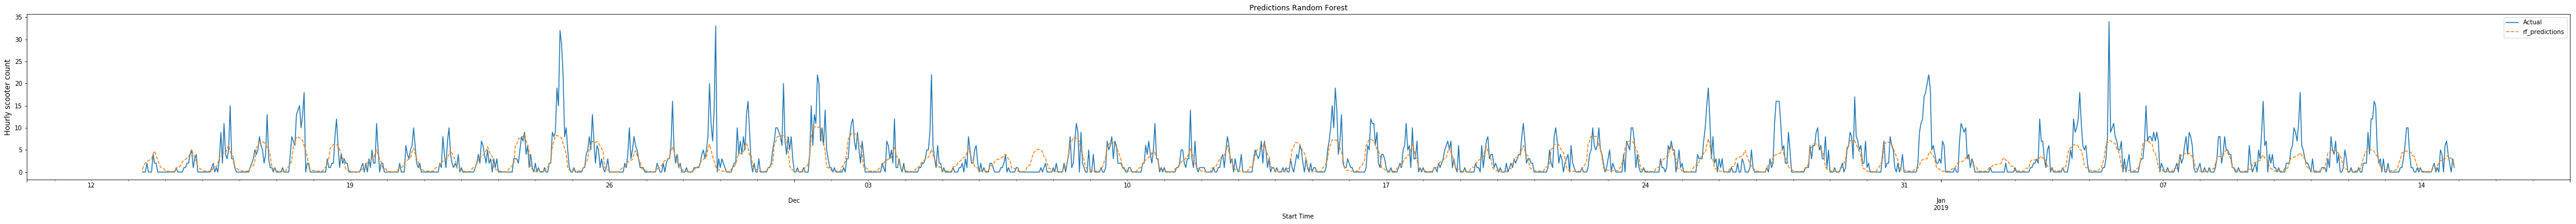

In [59]:
test_results.plot(style=['-', '--', ':'],figsize=(75, 5))
plt.title('Predictions Random Forest')
plt.ylabel('Hourly scooter count', fontsize=12)
plt.savefig('../../output/Random_Forest_Predictions_Commuter_Hours.png')

In [27]:
def groupbyCommute(df,hours=[0, 6, 10, 15, 19, 23]):

    # Bin hours
    if hours:
        df['HOUR_label'] = pd.cut(df['HOUR'], hours, include_lowest=True, right=True, labels=['Early', 'Commute_to_work', 'Afternoon', 'Commute_from_work', 'Night'])
#         df['HOUR'] = df['HOUR'].astype('str')
#         df = df.groupby(['DATE', 'HOUR'])['014706'].sum()
#         df = df.reset_index()

    return df





In [93]:

hours=[0, 6, 10, 15, 19, 23]
data_014706_2_hour['HOUR_label'] = pd.cut(data_014706_2_hour['HOUR'], hours, include_lowest=True, right=True, labels=['0', '1', '2', '3', '4'])



In [94]:

data_014706_2_hour.tail(5)

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE,HOUR_label
Start Time,,,,,,,,,,,,,,,,
2019-01-14 17:00:00,4,1,2019,17,14,3,0,0.0,1.0,6.26,0.0,0.0,44.0,51.0,34.0,3
2019-01-14 18:00:00,2,1,2019,18,14,3,0,0.0,1.0,6.26,0.0,0.0,44.0,51.0,34.0,3
2019-01-14 19:00:00,0,1,2019,19,14,3,0,0.0,1.0,6.26,0.0,0.0,44.0,51.0,34.0,3
2019-01-14 20:00:00,3,1,2019,20,14,3,0,0.0,1.0,6.26,0.0,0.0,44.0,51.0,34.0,4
2019-01-14 21:00:00,1,1,2019,21,14,3,0,0.0,1.0,6.26,0.0,0.0,44.0,51.0,34.0,4


In [79]:
data_014706_2_hour = data_014706_2_hour.drop(['SNOW'], axis=1)

In [95]:
size = int(len(data_014706_2_hour) * 0.66)
train, test = data_014706_2_hour[0:size], data_014706_2_hour[size:len(data_014706_2_hour)]
y_train = train.pop('014706').values
X_train = train.values
y_test = test.pop('014706').values
X_test = test.values

In [96]:
# After removing the hour 
best_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

best_rf.fit(X_train, y_train)
best_random_forest_accuracy = evaluate(best_rf, X_test, y_test)

Model Performance
Mean Square Error: 9.790583648697464
Mean Absoulute Error: 1.7474866709825287
Score: 0.41633119498586313


In [97]:
for i,j in  zip(train.columns.tolist(), best_rf.feature_importances_):
    print(i, ":", j)

MONTH : 0.016333019283797587
YEAR : 0.0
HOUR : 0.41499837387831723
DAY : 0.037937978349009575
WEEK : 0.036726663368865306
DAY_OF_WEEK : 0.05973083918556861
WEEKEND : 0.005920565097914403
WEEKDAY : 0.010740508187474346
AVG_DAILY_WIND_SPEED : 0.030723857576177228
PRECIPITATION : 0.026194306510842997
SNOW : 0.0
AVG_TEMPERATURE : 0.0287212968516416
MAX_TEMPERATURE : 0.038041386377396444
MIN_TEMPERATURE : 0.02456326118561861
HOUR_label : 0.26936794414737597


In [99]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3,5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'oob_score': [True, False],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(X_train, y_train)
#print("Grid Search Best Parameters:" grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=False 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=False 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=False 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, oob_score=True 
[CV] bootstrap=True, max_depth=80, max_features=2,

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=True, total=   4.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=True, total=   4.1s
[CV] bootstrap=True, max_depth=80, max_features=

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=False 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_sam

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2,

[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.6s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.4s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True, total=   3.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True, total=   3.4s
[CV] bootstrap=True, max_depth=80, max_features=2, 

[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=False, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_sam

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3

[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.4s
[CV] bootstrap=True, max_depth=80, max_feature

[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=False, total=   3.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_l

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_featur

[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_sampl

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.3s
[CV] bootstrap=True, max_depth=80, max_featur

[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=True, total=   1.3s
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.2s
[CV]  bootstrap=True, max_depth=80, max_features=5, 

[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=5

[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3,

[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True, total=   4.3s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=False, total=   3.9s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True, total=   4.1s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=

[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.2s
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_feature

[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=

[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_sample

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.1min


[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.9s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_sam

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2,

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=False, total=   3.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=True, total=   3.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=False, total=   3.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=False, total=   3.1s
[CV] bootstrap=True, max_depth=90, max_featur

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=True, total=   1.0s
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=False 
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_sa

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=True, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=True, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, mi

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.6s
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False 
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=True, total=   3.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_sample

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False 
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV] bootstrap=True, max_depth=90, max_features=2, min_samp

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.0s
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True 
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=True, total=   3.8s
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=True, total=   3.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True 
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=False, total=   3.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_l

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=True, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_featur

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.2min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_featur

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_sampl

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False 
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_sampl

[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=True, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_lea

[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=5

[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4,

[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True, total=   4.4s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True, total=   4.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=False, total=   4.1s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=False, total=   3.9s
[CV] bootstrap=True, max_depth=90, max_features=

[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samp

[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=

[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_sample

[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True, total=   4.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=False, total=   3.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True, total=   4.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=False, total=   3.8s
[CV] bootstrap=True, max_depth=100, max_fe

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, oob_score=False, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, oob_score=True, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, oob_score=True, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=2,

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.3s
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, oob_score=True, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, oob_score=False 
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.3s
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=True 
[CV] bootstrap=True, max_depth=100, max_featur

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True, total=   3.5s
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True, total=   3.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=True 
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=100, 

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.7min


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True, total=   3.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True, total=   3.3s
[CV] bootstrap=True, max_depth=100, max_feat

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=True, total=   3.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=2, 

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_fe

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.7s
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=100, max

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_sam

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_fe

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.7s
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True 
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_sample

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=False, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=False, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=True, total=   3.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=False, total=   3.2s
[CV] bootstrap=True, max_depth=100, max

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=3

[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=100, max

[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=True, total=   4.3s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, m

[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=False, total=   4.1s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=False, total=   4.2s
[CV] bootstrap=True, max_depth=100, max_

[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.3s
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, oob_score=False 
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5,

[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_feature

[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=True, total=   4.4s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=True, total=   4.5s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=False, total=   4.2s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_

[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False 
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=False, total=   4.1s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=5, m

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_s

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.5min


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=True, total=   3.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, oob_score=True, total=   3.5s
[CV] bootstrap=True, max_depth=110, max_f

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=True, total=   3.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2,

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False, total=   0.3s
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, oob_score=True 
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, oob_score=True, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True, total=   3.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=False, total=   3.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True, total=   3.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_sa

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=True, total=   3.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=2, m

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.3s
[CV]  bootstrap=True, max_depth=110, max_featur

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.4s
[CV] bootstrap=True, max_depth=110, 

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_s

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False, total=   0.3s
[CV] bootstrap=True, max_depth=110, max

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, oob_score=True, total=   3.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_sam

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=False, total=   3.3s
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=False 
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=False, total=   3.4s
[CV] bootstrap=True, max_depth=110, m

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, mi

[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200, oob_score=True, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_

[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=True, total=   4.4s
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=True, total=   4.5s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, oob_score=False, total=   4.1s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, m

[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=False 
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, oob_score=True, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=5, min_sampl

[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=True 
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_

[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=100, oob_score=False, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.8s
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=True 
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, oob_score=False, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features

[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=True, total=   4.0s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=False, total=   3.8s
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, oob_score=False, total=   4.1s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=False 
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=5, mi

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  8.5min


[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, oob_score=False, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=False 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, oob_score=False, total=   3.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, oob_score=True 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300, oob_score=True, total=   1.3s
[CV] bootstrap=True, max_depth=110, 

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10b0f44b0, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10b0f44b0, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(15, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(15, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (15, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=15, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import GridSearchCV...id_accuracy = evaluate(best_grid, X_test, y_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 4, 8, 20, 13, 28, 205343, tzinfo=tzutc()), 'msg_id': '0d8b0af80f924b75bec6e50e8ce0269c', 'msg_type': 'execute_request', 'session': 'ee938e08706a4411990d6301626cdc06', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '0d8b0af80f924b75bec6e50e8ce0269c', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'ee938e08706a4411990d6301626cdc06']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import GridSearchCV...id_accuracy = evaluate(best_grid, X_test, y_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 4, 8, 20, 13, 28, 205343, tzinfo=tzutc()), 'msg_id': '0d8b0af80f924b75bec6e50e8ce0269c', 'msg_type': 'execute_request', 'session': 'ee938e08706a4411990d6301626cdc06', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '0d8b0af80f924b75bec6e50e8ce0269c', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'ee938e08706a4411990d6301626cdc06'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import GridSearchCV...id_accuracy = evaluate(best_grid, X_test, y_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 4, 8, 20, 13, 28, 205343, tzinfo=tzutc()), 'msg_id': '0d8b0af80f924b75bec6e50e8ce0269c', 'msg_type': 'execute_request', 'session': 'ee938e08706a4411990d6301626cdc06', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '0d8b0af80f924b75bec6e50e8ce0269c', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.model_selection import GridSearchCV...id_accuracy = evaluate(best_grid, X_test, y_test)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.model_selection import GridSearchCV...id_accuracy = evaluate(best_grid, X_test, y_test)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.model_selection import GridSearchCV...id_accuracy = evaluate(best_grid, X_test, y_test)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.model_selection import GridSearchCV...id_accuracy = evaluate(best_grid, X_test, y_test)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.model_selection import GridSearchCV...id_accuracy = evaluate(best_grid, X_test, y_test)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'from sklearn.model_selection import GridSearchCV...id_accuracy = evaluate(best_grid, X_test, y_test)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.model_selection import GridSearchCV...id_accuracy = evaluate(best_grid, X_test, y_test)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-99-bdd1b75ee1bc>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1c21eb7ac8, execution...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1c1fc8dae0, file "<ipython-input-99-bdd1b75ee1bc>", line 20>
        result = <ExecutionResult object at 1c21eb7ac8, execution...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1c1fc8dae0, file "<ipython-input-99-bdd1b75ee1bc>", line 20>, result=<ExecutionResult object at 1c21eb7ac8, execution...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1c1fc8dae0, file "<ipython-input-99-bdd1b75ee1bc>", line 20>
        self.user_global_ns = {'ARIMA': <class 'statsmodels.tsa.arima_model.ARIMA'>, 'ARIMAResults': <class 'statsmodels.tsa.arima_model.ARIMAResults'>, 'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'ArmaProcess': <class 'statsmodels.tsa.arima_process.ArmaProcess'>, 'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport da...e\nfrom data_pipeline import weather_data_pipeline', 'data_014706 = pd.read_pickle("../../data/pickled...= weather_data.drop([\'level_0\', \'index\'], axis=1)', 'data_014706.head(5)', 'data_014706_2 = data_014706\ndata_014706_2 = data...14706_2_hour.fillna(0)\ndata_014706_2_hour.head(5)', '# Do the resampling before you add all the featu...706_2_hour.index).date\ndata_014706_2_hour.head(5)', "# Add Weather Data \ndata_014706_2_hour = data_01...2_hour.drop(['DATE', 'index', 'level_0'], axis=1)", "data_014706_2_hour = data_014706_2_hour.drop(['DATE', 'index', 'level_0'], axis=1)", "data_014706_2_hour = data_014706_2_hour.drop(['DATE'], axis=1)", 'data_014706_2_hour.columns', "# Create the test train split the same way as th...p('index')\n# test.pop('DATE')\n# test.pop('index')", "y_train = train.pop('014706').values\nX_train = t... = test.pop('014706').values\nX_test = test.values", 'def evaluate(model, test_features, test_labels):...ons))\n    print("Score:", score)\n    return score', 'best_rf = RandomForestRegressor(bootstrap=True, ...rest_accuracy = evaluate(best_rf, X_test, y_test)', 'best_rf_predictions = best_rf.predict(X_test)', 'train.head(5)', 'for i,j in  zip(train.columns.tolist(), best_rf.feature_importances_):\n    print(i, ":", j)', 'size = int(len(data_014706_2_hour) * 0.66)\ntrain... data_014706_2_hour[size:len(data_014706_2_hour)]', "test_results = test_1.drop(['MONTH', 'YEAR', 'HO...tolist()\ntest_results['rf_predictions'] = rf_list", 'test_results.head(5)', ...], 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {3:                      014706  MONTH  YEAR  HOUR  ...         86.0             98.0             75.0  , 4:                      014706
Start Time          ...7-15 03:00:00       0
2018-07-15 04:00:00       0, 5:                      014706  MONTH  YEAR  HOUR  ...18-07-15 04:00:00      1.0      0.0  2018-07-15  , 6:                      014706  MONTH  YEAR  HOUR  ...    75.0  
2018-07-15 04:00:00             75.0  , 9: Index(['014706', 'MONTH', 'YEAR', 'HOUR', 'DAY',...ATURE', 'MIN_TEMPERATURE'],
      dtype='object'), 15:                      MONTH  YEAR  HOUR  DAY  WEE...         86.0             98.0             75.0  , 19:                      Actual  rf_predictions
Star...74968
2018-11-13 13:00:00       0        2.241983, 21:                      014706  MONTH  YEAR  HOUR  ...         86.0             98.0             75.0  , 22:                      014706  MONTH  YEAR  HOUR  ...    75.0  
2018-07-15 04:00:00             75.0  , 30:                      014706  MONTH  YEAR   HOUR ...    75.0  
2018-07-15 04:00:00             75.0  , ...}, ...}
        self.user_ns = {'ARIMA': <class 'statsmodels.tsa.arima_model.ARIMA'>, 'ARIMAResults': <class 'statsmodels.tsa.arima_model.ARIMAResults'>, 'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'ArmaProcess': <class 'statsmodels.tsa.arima_process.ArmaProcess'>, 'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport da...e\nfrom data_pipeline import weather_data_pipeline', 'data_014706 = pd.read_pickle("../../data/pickled...= weather_data.drop([\'level_0\', \'index\'], axis=1)', 'data_014706.head(5)', 'data_014706_2 = data_014706\ndata_014706_2 = data...14706_2_hour.fillna(0)\ndata_014706_2_hour.head(5)', '# Do the resampling before you add all the featu...706_2_hour.index).date\ndata_014706_2_hour.head(5)', "# Add Weather Data \ndata_014706_2_hour = data_01...2_hour.drop(['DATE', 'index', 'level_0'], axis=1)", "data_014706_2_hour = data_014706_2_hour.drop(['DATE', 'index', 'level_0'], axis=1)", "data_014706_2_hour = data_014706_2_hour.drop(['DATE'], axis=1)", 'data_014706_2_hour.columns', "# Create the test train split the same way as th...p('index')\n# test.pop('DATE')\n# test.pop('index')", "y_train = train.pop('014706').values\nX_train = t... = test.pop('014706').values\nX_test = test.values", 'def evaluate(model, test_features, test_labels):...ons))\n    print("Score:", score)\n    return score', 'best_rf = RandomForestRegressor(bootstrap=True, ...rest_accuracy = evaluate(best_rf, X_test, y_test)', 'best_rf_predictions = best_rf.predict(X_test)', 'train.head(5)', 'for i,j in  zip(train.columns.tolist(), best_rf.feature_importances_):\n    print(i, ":", j)', 'size = int(len(data_014706_2_hour) * 0.66)\ntrain... data_014706_2_hour[size:len(data_014706_2_hour)]', "test_results = test_1.drop(['MONTH', 'YEAR', 'HO...tolist()\ntest_results['rf_predictions'] = rf_list", 'test_results.head(5)', ...], 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {3:                      014706  MONTH  YEAR  HOUR  ...         86.0             98.0             75.0  , 4:                      014706
Start Time          ...7-15 03:00:00       0
2018-07-15 04:00:00       0, 5:                      014706  MONTH  YEAR  HOUR  ...18-07-15 04:00:00      1.0      0.0  2018-07-15  , 6:                      014706  MONTH  YEAR  HOUR  ...    75.0  
2018-07-15 04:00:00             75.0  , 9: Index(['014706', 'MONTH', 'YEAR', 'HOUR', 'DAY',...ATURE', 'MIN_TEMPERATURE'],
      dtype='object'), 15:                      MONTH  YEAR  HOUR  DAY  WEE...         86.0             98.0             75.0  , 19:                      Actual  rf_predictions
Star...74968
2018-11-13 13:00:00       0        2.241983, 21:                      014706  MONTH  YEAR  HOUR  ...         86.0             98.0             75.0  , 22:                      014706  MONTH  YEAR  HOUR  ...    75.0  
2018-07-15 04:00:00             75.0  , 30:                      014706  MONTH  YEAR   HOUR ...    75.0  
2018-07-15 04:00:00             75.0  , ...}, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/Users/sameerabalay/Google Drive/Galvanize/DataScience/DSI/Final_Capstone/src/Top_Cell_Analysis/<ipython-input-99-bdd1b75ee1bc> in <module>()
     15 grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
     16                           cv = 3, n_jobs = -1, verbose = 2)
     17 
     18 
     19 # Fit the grid search to the data
---> 20 grid_search.fit(X_train, y_train)
     21 #print("Grid Search Best Parameters:" grid_search.best_params_)
     22 
     23 best_grid = grid_search.best_estimator_
     24 grid_accuracy = evaluate(best_grid, X_test, y_test)

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e...ain_score='warn',
       scoring=None, verbose=2), X=array([[7, 2018, 0, ..., 98.0, 75.0, '0'],
     ...1, 2018, 8, ..., 49.0, 34.0, '1']], dtype=object), y=array([1, 0, 0, ..., 0, 0, 1]), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X = array([[7, 2018, 0, ..., 98.0, 75.0, '0'],
     ...1, 2018, 8, ..., 49.0, 34.0, '1']], dtype=object)
        y = array([1, 0, 0, ..., 0, 0, 1])
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Apr  8 15:21:58 2019
PID: 25452                              Python 3.6.5: /anaconda3/bin/python
...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestRegressor(bootstrap=False, criterion...ate=None,
           verbose=0, warm_start=False), array([[7, 2018, 0, ..., 98.0, 75.0, '0'],
     ...1, 2018, 8, ..., 49.0, 34.0, '1']], dtype=object), array([1, 0, 0, ..., 0, 0, 1]), {'score': <function _passthrough_scorer>}, array([ 971,  972,  973, ..., 2910, 2911, 2912]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    962, 963, 964, 965, 966, 967, 968, 969, 970]), 2, {'bootstrap': False, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestRegressor(bootstrap=False, criterion...ate=None,
           verbose=0, warm_start=False), array([[7, 2018, 0, ..., 98.0, 75.0, '0'],
     ...1, 2018, 8, ..., 49.0, 34.0, '1']], dtype=object), array([1, 0, 0, ..., 0, 0, 1]), {'score': <function _passthrough_scorer>}, array([ 971,  972,  973, ..., 2910, 2911, 2912]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    962, 963, 964, 965, 966, 967, 968, 969, 970]), 2, {'bootstrap': False, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestRegressor(bootstrap=False, criterion...ate=None,
           verbose=0, warm_start=False), X=array([[7, 2018, 0, ..., 98.0, 75.0, '0'],
     ...1, 2018, 8, ..., 49.0, 34.0, '1']], dtype=object), y=array([1, 0, 0, ..., 0, 0, 1]), scorer={'score': <function _passthrough_scorer>}, train=array([ 971,  972,  973, ..., 2910, 2911, 2912]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    962, 963, 964, 965, 966, 967, 968, 969, 970]), verbose=2, parameters={'bootstrap': False, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100, 'oob_score': True}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestRegr...te=None,
           verbose=0, warm_start=False)>
        X_train = array([[8, 2018, 11, ..., 102.0, 73.0, '2'],
   ...1, 2018, 8, ..., 49.0, 34.0, '1']], dtype=object)
        y_train = array([13,  5, 12, ...,  0,  0,  1])
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestRegressor(bootstrap=False, criterion...ate=None,
           verbose=0, warm_start=False), X=array([[8.000e+00, 2.018e+03, 1.100e+01, ..., 1....1, 3.400e+01,
        1.000e+00]], dtype=float32), y=array([[13.],
       [ 5.],
       [12.],
       ...,
       [ 0.],
       [ 0.],
       [ 1.]]), sample_weight=None)
    283 
    284         # Check parameters
    285         self._validate_estimator()
    286 
    287         if not self.bootstrap and self.oob_score:
--> 288             raise ValueError("Out of bag estimation only available"
    289                              " if bootstrap=True")
    290 
    291         random_state = check_random_state(self.random_state)
    292 

ValueError: Out of bag estimation only available if bootstrap=True
___________________________________________________________________________

In [100]:
data_014706_2_hour.head(5)

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE,HOUR_label
Start Time,,,,,,,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 01:00:00,0,7,2018,1,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 02:00:00,0,7,2018,2,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 03:00:00,0,7,2018,3,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 04:00:00,0,7,2018,4,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0


In [103]:
data_014706_2_hour['014706'].unique()

array([ 1,  0,  3,  6,  4,  2,  5,  7,  8, 12,  9, 10, 11, 21, 17, 16, 14,
       13, 15, 18, 20, 19, 24, 26, 32, 29, 22, 33, 34])

In [106]:
data_014706_2_hour[data_014706_2_hour['014706'] > 25]

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE,HOUR_label
Start Time,,,,,,,,,,,,,,,,
2018-09-22 15:00:00,26,9,2018,15,22,38,5,1.0,0.0,8.50,0.47,0.0,78.0,80.0,71.0,2
2018-11-24 16:00:00,32,11,2018,16,24,47,5,1.0,0.0,5.37,0.00,0.0,57.0,77.0,39.0,3
2018-11-24 17:00:00,29,11,2018,17,24,47,5,1.0,0.0,5.37,0.00,0.0,57.0,77.0,39.0,3
2018-11-28 21:00:00,33,11,2018,21,28,48,2,0.0,1.0,10.51,0.00,0.0,55.0,73.0,45.0,4
2019-01-05 13:00:00,34,1,2019,13,5,1,5,1.0,0.0,4.47,0.00,0.0,49.0,73.0,30.0,2
